_____

In [1]:
import os
import sys
sys.path.append("../utils/")
sys.path.append("../models/")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import UNet
from max_model import ENet3D as ENet
from nn_utils import iterate_minibatches
from mulptiprocessing_utils import par_iterate_minibatches
from pytorch_utils import to_numpy, to_var, loss_cross_entropy, stochastic_step
from data_utils import load_files, random_nonzero_crops, augment, _reshape_to
from data_utils import combine, divide
from metrics import hausdorff, dice
from model_controller import Model_controller

%matplotlib inline

In [2]:
PATH = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Utr/Utrecht/'
PATH1 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Sing/Singapore/'
PATH2 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Amst/GE3T/'

In [3]:
masks, t1, flairs, clear_flairs = load_files(PATH)
brains = np.concatenate([clear_flairs, t1], axis=1).astype(np.float32)

masks1, t11, flairs1, clear_flairs1 = load_files(PATH1)
brains1 = np.concatenate([clear_flairs1, t11], axis=1).astype(np.float32)

masks2, t12, flairs2, clear_flairs2 = load_files(PATH2)
brains2 = np.concatenate([clear_flairs2, t12], axis=1).astype(np.float32)

100%|██████████| 20/20 [00:06<00:00,  3.54it/s]


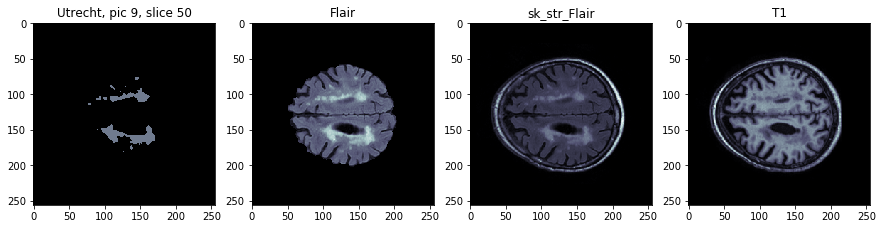

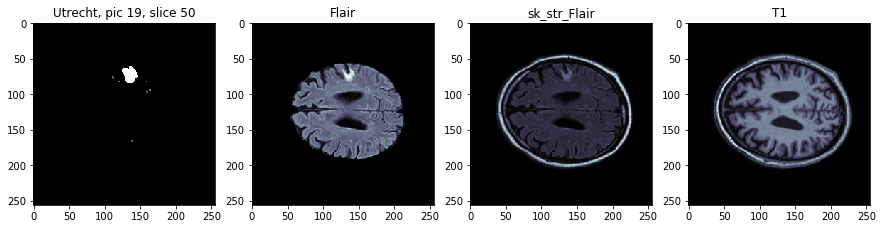

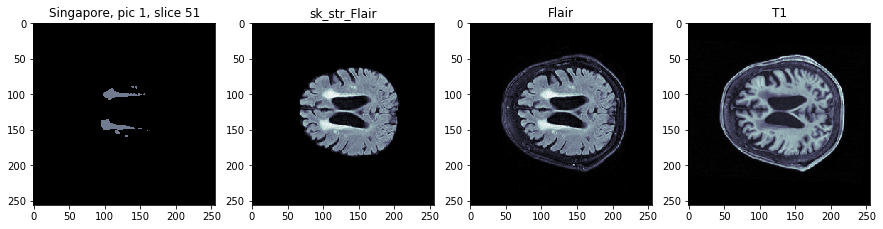

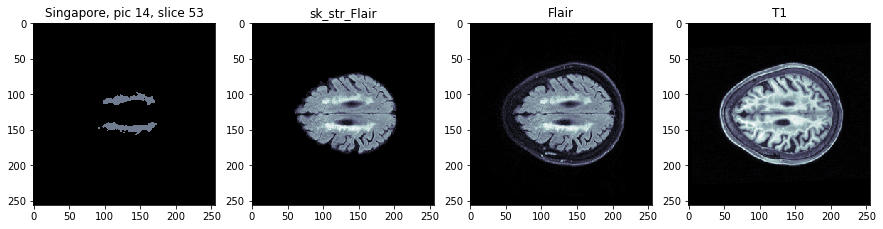

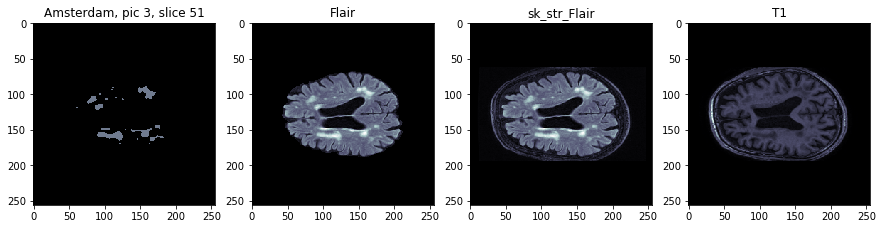

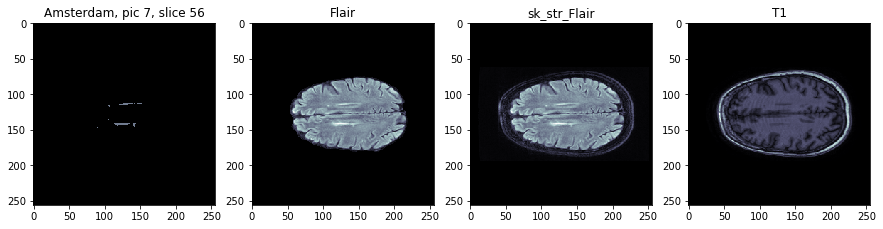

In [4]:
# Visualize

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks[pic, 0]
    flair = brains[pic, 0]
    tttt = brains[pic, 1]
    clr_flr = flairs[pic, 0]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,4,1)
    plt.title('Utrecht, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,4,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,3)
    plt.title('sk_str_Flair')
    plt.imshow(clr_flr[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,4)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks1[pic, 0]
    flair = brains1[pic, 0]
    tttt = brains1[pic, 1]
    clr_flr = flairs1[pic, 0]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,4,1)
    plt.title('Singapore, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,4,2)
    plt.title('sk_str_Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,3)
    plt.title('Flair')
    plt.imshow(clr_flr[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,4)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks2[pic, 0]
    flair = brains2[pic, 0]
    tttt = brains2[pic, 1]
    clr_flr = flairs2[pic, 0]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,4,1)
    plt.title('Amsterdam, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,4,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,3)
    plt.title('sk_str_Flair')
    plt.imshow(clr_flr[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,4,4)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

    
    
# for pic in np.random.choice(range(len(masks1)), 2, False):
#     plt.figure(figsize=(10,10))
#     mask = masks1[pic, 0]
#     flair = brains1[pic, 0]
#     tttt = brains1[pic, 1]
#     t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
#     plt.subplot(1,3,1)
#     plt.title('Singapore, pic '+ str(pic)+', slice ' + str(t))
#     plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
#     plt.subplot(1,3,2)
#     plt.title('Flair')
#     plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
#     plt.subplot(1,3,3)
#     plt.title('T1')
#     plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

# for pic in np.random.choice(range(len(masks2)), 2, False):
#     plt.figure(figsize=(10,10))
#     mask = masks2[pic, 0]
#     flair = brains2[pic, 0]
#     tttt = brains2[pic, 1]
#     t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
#     plt.subplot(1,3,1)
#     plt.title('Amsterdam, pic '+ str(pic)+', slice ' + str(t))
#     plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
#     plt.subplot(1,3,2)
#     plt.title('Flair')
#     plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
#     plt.subplot(1,3,3)
#     plt.title('T1')
#     plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

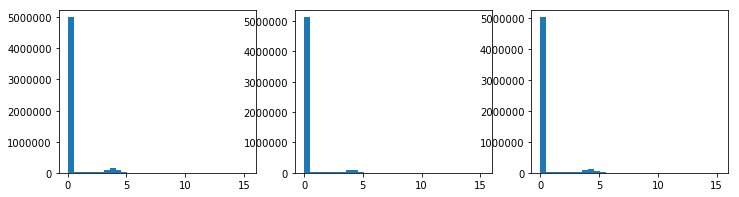

In [5]:
plt.figure(figsize=(12,3))
plt.title('hist of flairs');
plt.subplot(131)
a = plt.hist(brains[8, 0].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 0].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 0].flatten(), bins=a[1]);

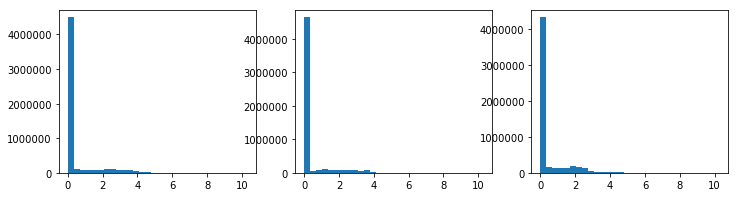

In [6]:
plt.figure(figsize=(12,3))
plt.title('hist of t1')
plt.subplot(131)
a = plt.hist(brains[8, 1].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 1].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 1].flatten(), bins=a[1]);

____

In [7]:
def get_train_split(get_train_split=20, n=15):
    return np.in1d(np.array(range(get_train_split)), 
                   np.random.choice(range(get_train_split), n, False))

In [8]:
idx1, idx2, idx3 = get_train_split(), get_train_split(), get_train_split()
idx1, idx2, idx3

(array([False,  True,  True,  True,  True, False,  True,  True, False,
         True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True], dtype=bool),
 array([ True,  True, False, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,
         True, False], dtype=bool),
 array([ True, False, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True], dtype=bool))

In [9]:
#train_test_split
X_train = np.concatenate([brains[idx1], brains1[idx2], brains2[idx3]])
X_test = np.concatenate([brains[~idx1], brains1[~idx2], brains2[~idx3]])
Y_train = np.concatenate([masks[idx1], masks1[idx2], masks2[idx3]])
Y_test = np.concatenate([masks[~idx1], masks1[~idx2], masks2[~idx3]])

X_train = np.concatenate([brains[idx1]])
X_test = np.concatenate([brains[~idx1]])
Y_train = np.concatenate([masks[idx1]])
Y_test = np.concatenate([masks[~idx1]])

In [10]:
X_train.shape, X_test.shape

((45, 2, 256, 256, 84), (15, 2, 256, 256, 84))

In [11]:
del brains, brains1, brains2, masks, masks1, masks2

___

In [12]:
model = UNet().cuda()

# model = ENet(3, 2).cuda()

controller = Model_controller(model)

controller.init_train_procedure(batch_size = 25, crops_shape=(50, 50, 40)) #crops_shape=(80, 80, 40))


In [ ]:
controller.train(X_train, Y_train, epoches=35, X_val=X_test, y_val=Y_test)

0.0244: 100%|██████████| 20/20 [00:37<00:00,  1.77s/it]


0 epoch: 
train loss 0.18919062260538339


0.0593: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


val loss 0.04632829576730728


0.0435: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


1 epoch: 
train loss 0.04574987152591348


0.0669: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


val loss 0.05108606070280075


0.0405: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


2 epoch: 
train loss 0.047600991651415826


0.0476: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


val loss 0.04944468811154366


0.0352: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


3 epoch: 
train loss 0.04112173654139042


0.0452: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


val loss 0.05786029398441315


0.1019: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


4 epoch: 
train loss 0.054435801412910226


0.0513: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


val loss 0.051681265234947205


0.0753: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


5 epoch: 
train loss 0.04609592510387302


0.0514: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


val loss 0.04274648055434227


0.0506: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


6 epoch: 
train loss 0.04606925752013922


0.0447: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


val loss 0.045039791613817215


0.0449: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


7 epoch: 
train loss 0.044759601820260286


0.0337: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


val loss 0.03937391489744187


0.0656:  45%|████▌     | 9/20 [00:16<00:19,  1.78s/it]

In [ ]:
y = controller.predict(X_test)

In [ ]:
y.shape, Y_test.shape, y.sum()

In [ ]:
for num_img in range(len(Y_test)):
    plt.figure()
    t = np.argmax(np.sum(Y_test[num_img, 0, ...]==1, axis=(-2, -3)))
    plt.subplot(121)
    plt.imshow(y[num_img, ..., t], cmap=plt.cm.binary_r)
    plt.title('dice: ' + str(dice(y[num_img], Y_test[num_img,0]))[:5] )
    plt.subplot(122)
    plt.imshow(Y_test[num_img, 0,..., t], cmap=plt.cm.binary_r, vmax=2)
    
# plt.savefig('../reports/figures/3D_UNet/'+str(i)+'.png')

#  with open('../reports/figures/3D_UNet/README.md', 'w') as f:
#             for i in range(len(X_test)):
#                 f.write('![./figures/3D_UNet/'+str(i)+'.png](./figures/3D_UNet/'+str(i)+'.png)\n')
        

In [ ]:
plt.plot(controller.res['lr'])

In [ ]:
plt.plot(controller.res['train_loss'])
plt.plot(controller.res['val_loss'])

___

In [ ]:
import pickle
with open('../models/dumps/model_unetcnn.pkl', 'wb') as f:
    pickle.dump(controller.model.state_dict(), f, protocol=pickle.HIGHEST_PROTOCOL)